# Stock market portfolio optimisation.

The goal of this notebook is to provide an introduction to stock market portfolio optimisation using Python. 
We will use pandas_datareader module to get data and PyPortfolioOpt for optimisation. 
We will walk through a simple Python script to retrieve, analyze, and visualize data for predefined portfolio of stocks. 

To read and use this notebook clone it from remote repository to your local computer and run in preferred environment.

Permanent link to repository: [bitbucket.org/Nekrasovp/stock-market-portfolio-optimisation](https://bitbucket.org/Nekrasovp/stock-market-portfolio-optimisation)

You can view this notebook on Jupyter Notebook *nbviewer* website: [nbviewer.jupyter.org/urls/bitbucket.org/Nekrasovp/stock-market-portfolio-optimisation](https://nbviewer.jupyter.org/urls/bitbucket.org/Nekrasovp/stock-market-portfolio-optimisation/raw/521575bd0a5fcdc80621e57f572313b98c312619/Stock%20market%20portfolio%20optimisation.ipynb)

### Table of content:
- [Project setup](#project-setup)
- [Pulling data](#Pulling-data)
- [Preparing data](#Preparing-data)
- [Analyze portfolio](#Analyze-portfolio)
    * Calculate the 'Markowitz portfolio', minimising volatility for a given target return.
    * Calculate the Sharpe-maximising portfolio for a given volatility (i.e max return for a target risk).
- [Visualise portfolio](#Visualise-portfolio)
    * Widget that allows you to interactively change the allocation.
    * Plot with individual stock's annual return and annual risk, efficient frontier curve and best allocation cases.

# Project setup

First thing we'll do is import the required dependencies.

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, IntText, HBox, Layout, VBox, interact, Dropdown
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We will use <a href="https://pydata.github.io/pandas-datareader/stable/index.html">pandas_datareader</a> to get data from the market. And <a href="https://pyportfolioopt.readthedocs.io/en/latest/">pypfopt</a> for optimisation goals.

In [42]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, discrete_allocation

In [43]:
import pandas_datareader as pdr

Making the same request repeatedly can use a lot of bandwidth, slow down your code and may result in your IP being banned.

pandas_datareader allows you to cache queries using requests_cache

In [44]:
import requests_cache
expire_after = timedelta(days=1)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)

In [45]:
%reload_ext watermark
%watermark -v -m --iversions

matplotlib        3.1.1
pandas            0.24.2
requests_cache    0.5.0
pandas_datareader 0.7.0
numpy             1.16.4
CPython 3.7.3
IPython 7.6.1

compiler   : GCC 8.0.1 20180414 (experimental) [trunk revision 259383
system     : Linux
release    : 4.15.0-54-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


# Pulling data

Define tickers you would like to analyze

In [46]:
securities = ['PRSP', 
              'GOOGL',
              'IBM',
              'BTI',
              'BA',
              'BIDU',
              'CMA',
              'WDC',
              'SLB',
              'SKM',
              'F',
              'EIX',
              'FAST',
              'NOK',
              'DLR',
              'INTC',
              'CBPO',
              'NVDA',
              'SHI',
              'CAT', ]

sec_data = {}
for security in securities:
    sec_df = pdr.DataReader(security,  
                            'yahoo', 
                            start=datetime(2018, 7, 10), 
                            end=datetime(2019, 7, 10), 
                            session=session)
    sec_data[security] = sec_df


By looking at keys of resulted dict we can explore which securities we fetched successfully.

In [47]:
sec_data.keys()

dict_keys(['PRSP', 'GOOGL', 'IBM', 'BTI', 'BA', 'BIDU', 'CMA', 'WDC', 'SLB', 'SKM', 'F', 'EIX', 'FAST', 'NOK', 'DLR', 'INTC', 'CBPO', 'NVDA', 'SHI', 'CAT'])

In [48]:
sec_data['GOOGL'].head()

High          Low         Open        Close   Volume  \
Date                                                                      
2018-07-10  1173.500000  1162.560059  1169.989990  1167.140015  1066700   
2018-07-11  1180.439941  1155.369995  1155.619995  1171.459961  1662600   
2018-07-12  1201.989990  1173.099976  1174.859985  1201.260010  2207400   
2018-07-13  1210.439941  1195.290039  1202.800049  1204.420044  1630600   
2018-07-16  1208.709961  1193.400024  1203.810059  1196.510010  1339200   

              Adj Close  
Date                     
2018-07-10  1167.140015  
2018-07-11  1171.459961  
2018-07-12  1201.260010  
2018-07-13  1204.420044  
2018-07-16  1196.510010

Let's look at how the price of each stock has evolved within give time frame.
While price of each stock is different there is no meaning to look at prices 
themselves so we will plot daily returns (percent change compared to the day before). 
By plotting daily returns instead of actual prices, we can see the stocks' volatility.

Text(0, 0.5, 'daily returns')

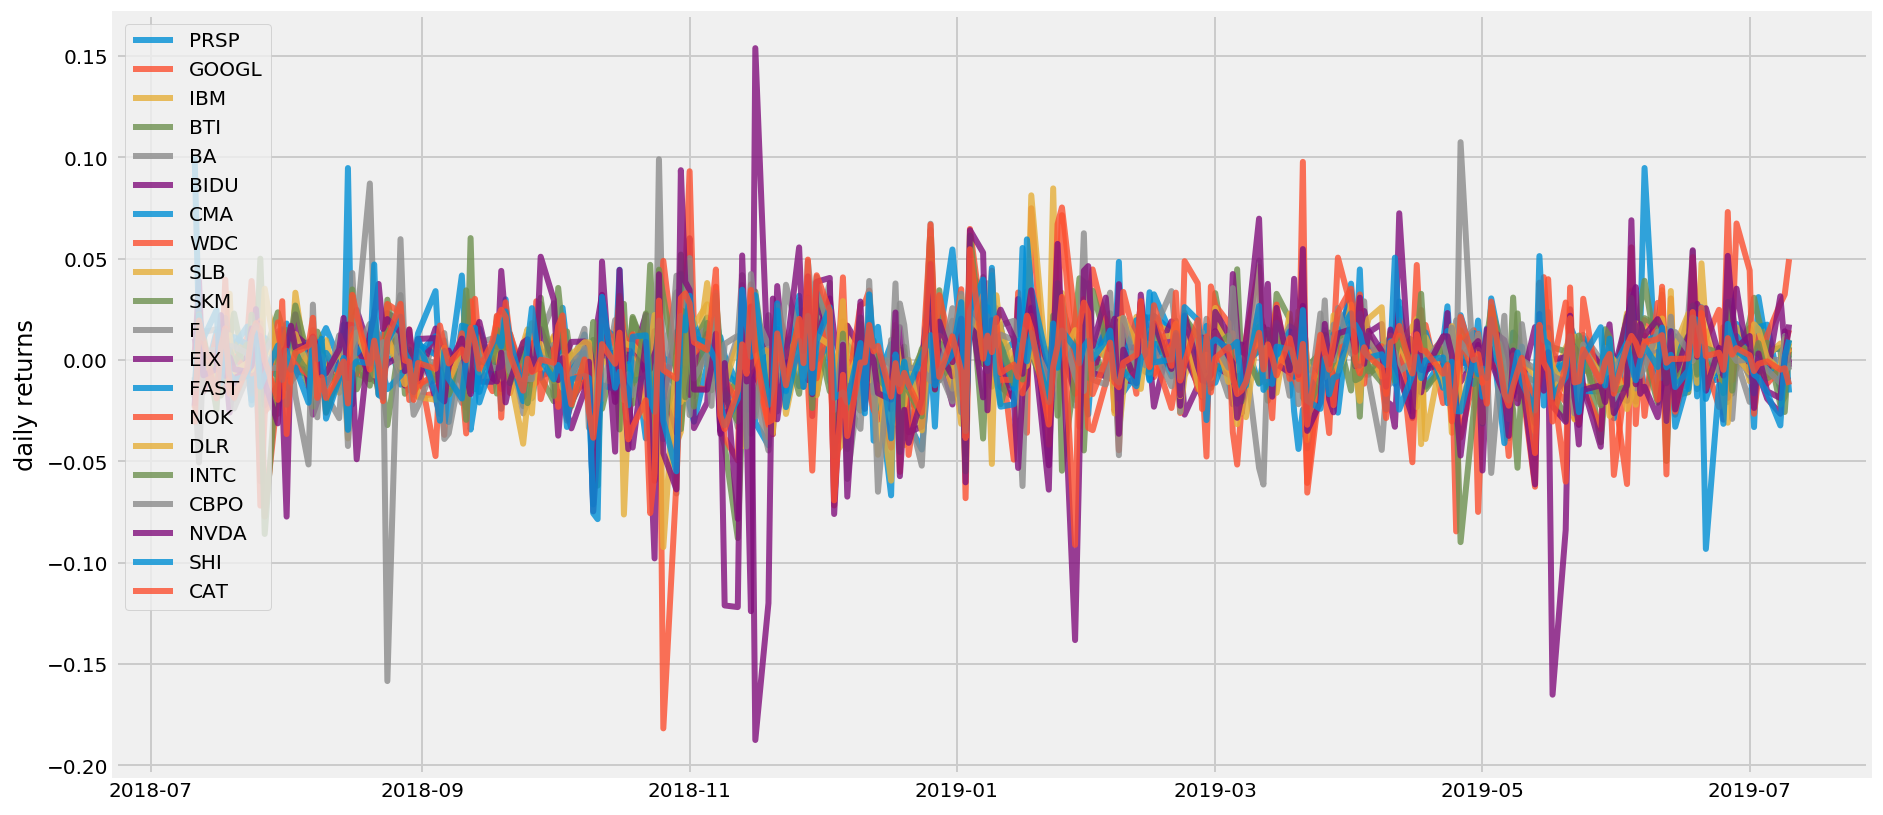

In [49]:
plt.figure(figsize=(14, 7))
for security, df in sec_data.items():
    df['PctChange'] = df.Close.pct_change()
    plt.plot(df.index, df.PctChange, lw=3, alpha=0.8,label=security)
plt.legend(loc='upper left', fontsize=10)
plt.ylabel('daily returns')

It seems that EIX has experienced a real "roller coaster" in the study period.

Text(0, 0.5, 'price in $')

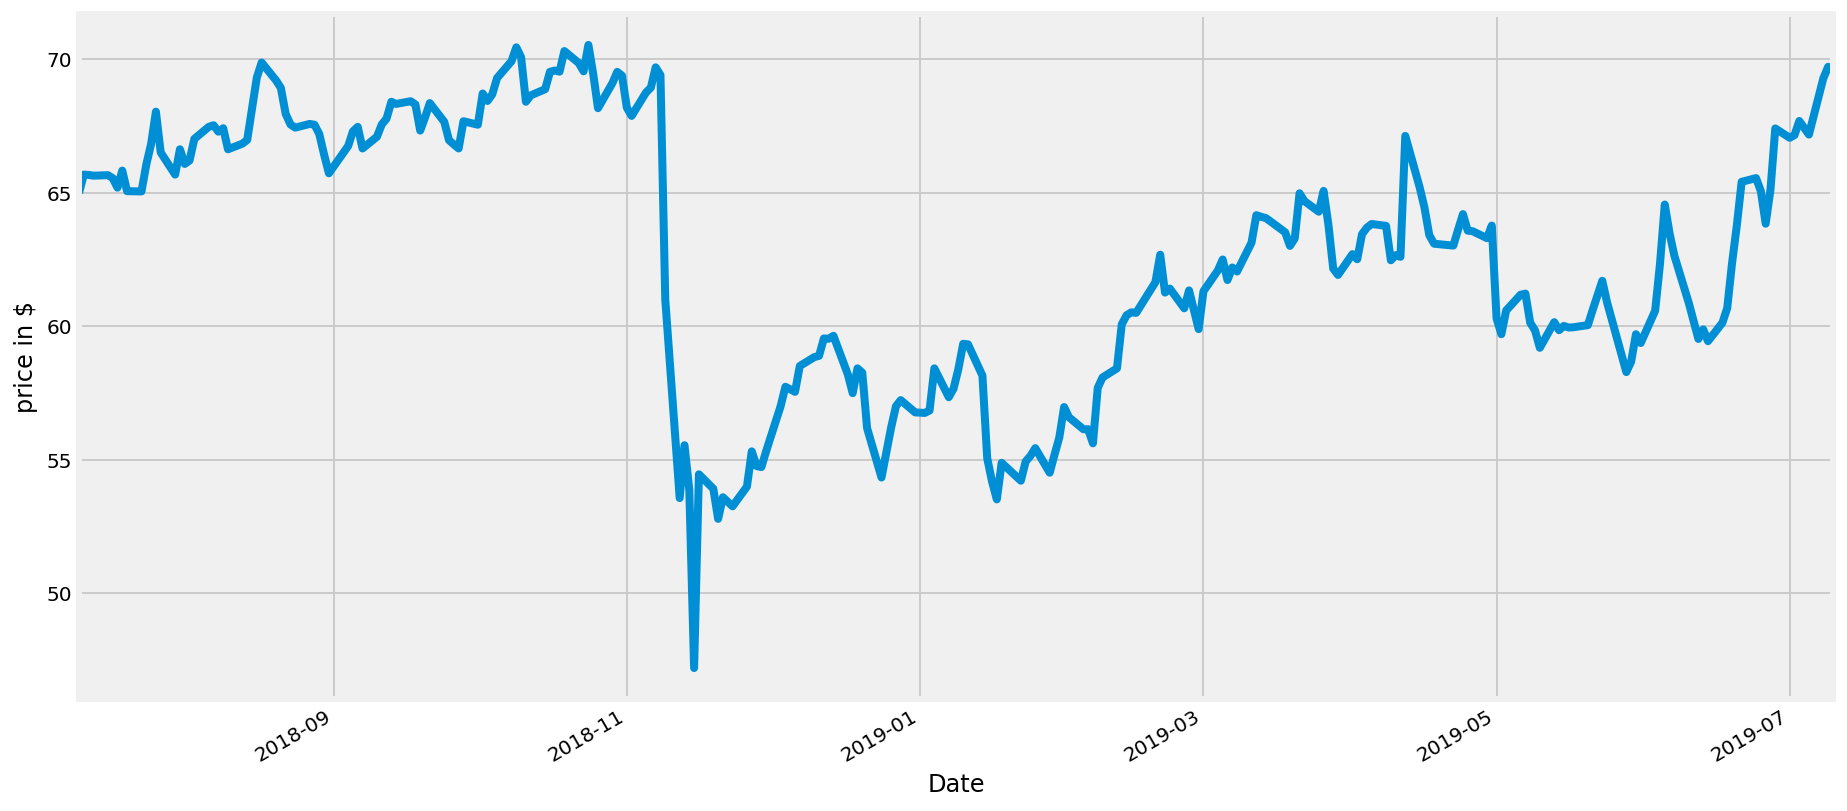

In [50]:
sec_data['EIX']['Close'].dropna().plot(figsize = (14, 7))
plt.ylabel('price in $')

Now we have a dictionary of dataframes, each containing the historical ohlcv prices data.

# Preparing data

For analyzing we will use only Close prices from each ohlcv tuple.

In [51]:
 def build_pricing_data_from_ohlcv(ohlcv_data: dict):
        """
        Build new pricing dict from ohlcv_data 'Close' column

        Add base asset column with price equal to '1'.

        :param ohlcv_data: Pricing data
        :return: Formated pricing data dict
        """
        data_c = pd.DataFrame()
        for m, ohlcv in ohlcv_data.items():
            data_c[m] = ohlcv['Close']
        return data_c

In [52]:
prices_df = build_pricing_data_from_ohlcv(sec_data)

In [53]:
pd.set_option('display.max_columns', 10)
prices_df.head()

PRSP        GOOGL         IBM        BTI          BA  ...  \
Date                                                                   ...   
2018-07-10  22.250000  1167.140015  144.710007  52.250000  347.160004  ...   
2018-07-11  22.559999  1171.459961  144.940002  51.380001  340.600006  ...   
2018-07-12  22.809999  1201.260010  146.449997  51.740002  346.029999  ...   
2018-07-13  22.870001  1204.420044  145.899994  51.799999  350.790009  ...   
2018-07-16  22.770000  1196.510010  145.460007  51.090000  356.100006  ...   

                 INTC        CBPO        NVDA        SHI         CAT  
Date                                                                  
2018-07-10  52.160000  106.720001  253.250000  60.139999  141.250000  
2018-07-11  51.200001  105.809998  247.529999  59.200001  136.759995  
2018-07-12  52.349998  100.459999  251.229996  60.500000  139.419998  
2018-07-13  52.220001  100.889999  249.320007  61.150002  140.750000  
2018-07-16  52.009998  101.400002  248.199997  62.650002  138.080002  

[5 rows x 20 columns]

# Analyze portfolio

Methods of "portfolio optimization" as a solution to a particular optimization problem is a widely studied area of human knowledge.

Look more here:

- <a href='https://colab.research.google.com/github/cvxgrp/cvx_short_course/blob/master/applications/portfolio_optimization.ipynb#scrollTo=QQDQCwAeWw96'>Stanford University Convex Optimization Group - Portfolio optimization</a>

- <a href='https://evgenypogorelov.com/portfolio-rebalancing-python.html#portfolio-rebalancing-python'>Portfolio Rebalancing Using Python</a>

- <a href='https://github.com/tthustla/efficient_frontier/blob/master/Efficient%20_Frontier_implementation.ipynb'>
The Efficinet Frontier (Markowitz Portfolio Optimisation)</a>

As mentioned above we will use *PyPortfolioOpt* package because its provide 
clear and uncomplicated access to pandas and scipy optimisation methods used in our case.

- <a href='https://pyportfolioopt.readthedocs.io/'>Financial portfolio optimisation in python, including classical efficient frontier and advanced methods. </a>

- <a href='https://reasonabledeviations.science/2018/09/27/lessons-portfolio-opt/'>Portfolio optimisation: lessons learnt</a>

*Expected returns* models:
+ mean historical return
- exponentially weighted mean historical return

*Risk* models:
+ sample covariance
- semicovariance
- exponentially weighted covariance
- mininum covariance determinant
- shrunk covariance matrices:

    - manual shrinkage
    - Ledoit Wolf shrinkage
    - Oracle Approximating shrinkage

In [54]:
def generate_analysis_model(pricing_data, weight_bounds):
    """Generate efficient frontier model with simple and intuitive estimators

    :param pricing_data: Adjusted closing prices of the asset, each row is a date
               and each column is a ticker/id.
    :param weight_bounds: Minimum and maximum weight of an asset
    :return: Efficient Frontier model
    """
    # Annualised mean (daily) historical return from input (daily) asset prices
    mu = expected_returns.mean_historical_return(pricing_data, frequency=252)
    # Annualised sample covariance matrix of (daily) asset returns
    s = risk_models.sample_cov(pricing_data, frequency=252)
    return EfficientFrontier(mu, s, weight_bounds=weight_bounds, gamma=0)


In [55]:
def make_discrete_allocation(prices_df, cleaned_weights, total_portfolio_value):
    latest_prices = discrete_allocation.get_latest_prices(prices_df)
    da = discrete_allocation.DiscreteAllocation(weights=cleaned_weights,
                                                latest_prices=latest_prices,
                                                total_portfolio_value=total_portfolio_value
                                                )
    allocation, leftover = da.lp_portfolio(verbose=False)
    print(allocation)
    print("Funds remaining: ${:.2f}".format(leftover))

In [56]:
def draw_cleaned_weights_with_perfomance(cleaned_weights, p_perfomance):
    # Filter non-zero values
    non_zero_weights = dict(filter(lambda w: w[1] > 0.0, cleaned_weights.items()))
    # Plot horizontal bar chart with resulted weights
    plt.figure(figsize=(10, 7))
    _ = non_zero_weights
    ax = plt.barh(range(len(_.keys())), 
             [float(k)*100 for k in _.values()],
             align='center',
             height=0.5,
             color='#f3ba2f',
             edgecolor='black',
             tick_label=[k for k in _.keys()])
    plt.yticks(fontsize=14)
    plt.xlabel('Ticker allocation, %')
    plt.ylabel('Portfolio tickers')
    plt.title('Expected annual return: {:.2%} Annual volatility: {:.2%} Sharpe Ratio: {:.2f}'.format(
                p_perfomance[0],
                p_perfomance[1],
                p_perfomance[2]))
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        x_value = rect.get_width()
        y_value = rect.get_y() + rect.get_height() / 2
        # Number of points between bar and label. Change to your liking.
        space = 5
        # Vertical alignment for positive values
        ha = 'left'
        # If value of bar is negative: Place label left of bar
        if x_value < 0:
            # Invert space to place label to the left
            space *= -1
            # Horizontally align label at left
            ha = 'left'
        # Use X value as label and format number with one decimal place
        label = "{:.1f}".format(x_value)
        # Create annotation
        plt.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(space, 0),          # Horizontally shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            va='center',                # Vertically center label
            ha=ha)                      # Horizontally align label
    # plt.savefig("image.png")
    plt.show()

In [57]:
EFmodel = generate_analysis_model(prices_df, (0.0, 1.0))

### Calculate the 'Markowitz portfolio', minimising volatility for a given target return.

In [58]:
EFmodel.efficient_return(target_return=0.2) 

{'PRSP': 0.07457978484549457,
 'GOOGL': 0.0,
 'IBM': 0.0,
 'BTI': 0.0,
 'BA': 0.0,
 'BIDU': 3.754050022231059e-18,
 'CMA': 2.5343225781848666e-18,
 'WDC': 7.632783294297951e-17,
 'SLB': 5.0550926292136644e-18,
 'SKM': 0.09059050741712786,
 'F': 0.0,
 'EIX': 0.10282214987821588,
 'FAST': 0.6087972153096218,
 'NOK': 2.0477868532819965e-17,
 'DLR': 0.12321034254954018,
 'INTC': 0.0,
 'CBPO': 0.0,
 'NVDA': 0.0,
 'SHI': 1.6506978076091805e-17,
 'CAT': 0.0}

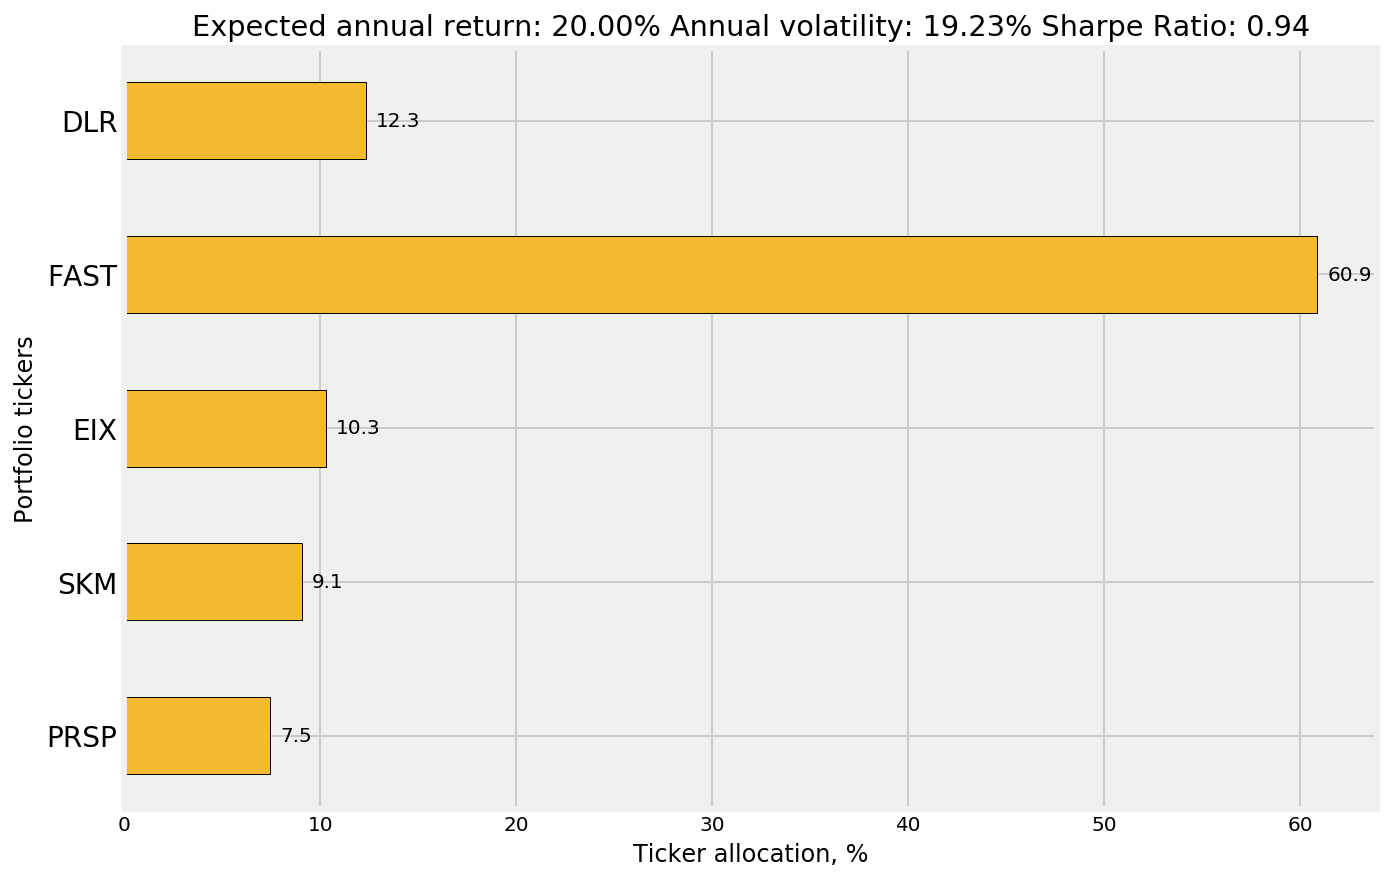

15 out of 20 tickers were removed
{'PRSP': 31, 'SKM': 37, 'EIX': 15, 'FAST': 195, 'DLR': 10}
Funds remaining: $7.08


In [59]:
cleaned_weights = EFmodel.clean_weights(cutoff=1e-4, rounding=4)
p_perfomance = EFmodel.portfolio_performance(verbose=False)
draw_cleaned_weights_with_perfomance(cleaned_weights, p_perfomance)
make_discrete_allocation(prices_df, cleaned_weights, 10000)

### You can do better than 1/N
Here is a quote from <a href='https://reasonabledeviations.science/2018/09/27/lessons-portfolio-opt/'>Portfolio optimisation: lessons learnt</a>:

"A significant body of research suggests that, in light of the aforementioned failures of MVO, we should instead use 1/N portfolios(<a href='https://www.semanticscholar.org/paper/Optimal-Versus-Naive-Diversification%3A-How-is-the-DeMiguel-Garlappi/5056fa2683e15c4c84d13c3dbfb949dc133850a3'>Optimal Versus Naive Diversification: How Inefficient is the 1/N Portfolio Strategy?</a>) – it is noted that they often beat efficient frontier optimisation significantly in out-of-sample testing.

However, an interesting paper by Kritzman et al. (2010) finds that it is not the case that there is anything special about 1/N diversification: it is just that the expected returns are an incredibly poor estimator and any optimisation scheme which relies on them will likely go astray.

The easiest way to avoid this problem is to not provide the expected returns to the optimiser, and just optimise on the sample covariance matrix instead. Effectively we are saying that although previous returns won’t predict future returns, previous risks might predict future risks. This is intuitively a lot more reasonable – the sample covariance matrix really seems like it should contain a lot of information. Empirical results support this, showing that minimum variance portfolios outperform both standard MVO and 1/N diversification.

In my own work I have found that the standard minimum variance portfolio is a very good starting point, from which you can try a lot of new things:

- Shrinkage estimators on the covariance matrix
- Exponential weighting
- Different historical windows
- Additional cost terms in the objective function (e.g small-weights penalty)
- ..."

### Calculate the Sharpe-maximising portfolio for a given volatility (i.e max return for a target risk).

In [60]:
EFmodel.efficient_risk(target_risk=0.25)

{'PRSP': 0.05055098383161007,
 'GOOGL': 4.934204086981531e-16,
 'IBM': 1.4046584533543294e-15,
 'BTI': 0.0,
 'BA': 0.0,
 'BIDU': 0.0,
 'CMA': 2.7773193900931803e-16,
 'WDC': 0.0,
 'SLB': 0.0,
 'SKM': 4.137525554375604e-15,
 'F': 0.0,
 'EIX': 0.11517889383646501,
 'FAST': 0.7954449526321907,
 'NOK': 5.570156423780059e-16,
 'DLR': 0.0388251696997469,
 'INTC': 7.154311323052942e-16,
 'CBPO': 2.3506926114837123e-15,
 'NVDA': 0.0,
 'SHI': 0.0,
 'CAT': 0.0}

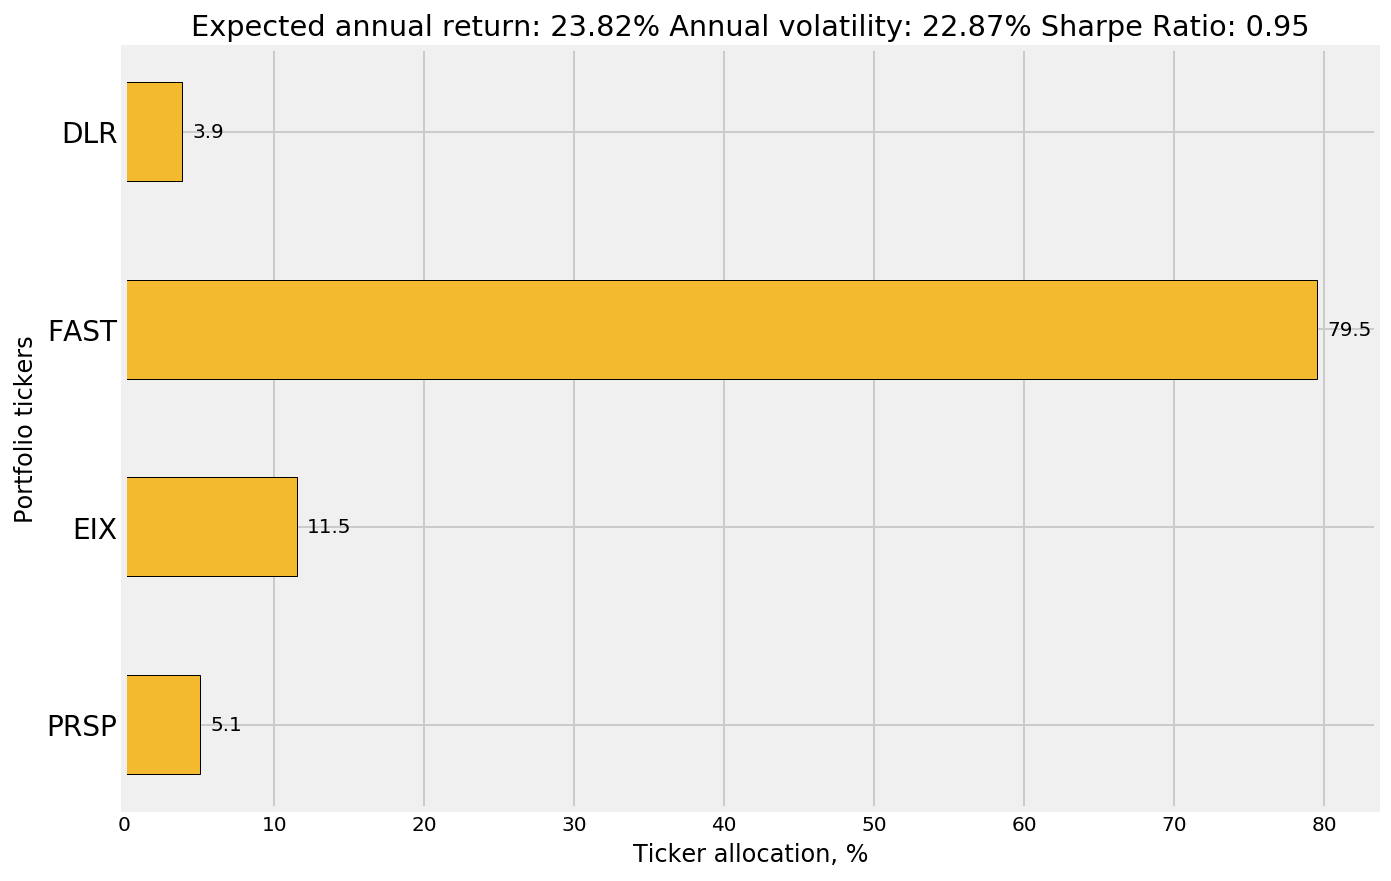

16 out of 20 tickers were removed
{'PRSP': 21, 'EIX': 17, 'FAST': 254, 'DLR': 3}
Funds remaining: $7.97


In [61]:
cleaned_weights = EFmodel.clean_weights(cutoff=1e-4, rounding=4)
p_perfomance = EFmodel.portfolio_performance(verbose=False)
draw_cleaned_weights_with_perfomance(cleaned_weights, p_perfomance)
make_discrete_allocation(prices_df, cleaned_weights, 10000)

# Visualise portfolio

One of the goal of this notebook is visualising Efficient portfolio. To achive this we will provide:
- Portfolio securities list.
- Maximum target return and minimum volatility cases information.
- Widget where you can choose different portfolio allocations along the Efficient frontier curve.
- Final allocations for presented portfolio value.

Next will plot:
- Individual stock's annual return and annual risk.
- Maximum target return and minimum volatility allocation.
- Efficient frontier curve.
- Target return portfolio perfomance

In [63]:
def generate_portfolio(prices_df, target_return = None, target_risk = None):
    """
    :return: Expected annual return(mu), Annual volatility(sigma), Sharpe Ratio
    """
    weight_bounds = (0.0, 1.0)
    EFmodel = generate_analysis_model(prices_df, weight_bounds)
    if target_return is not None:
        EFmodel.efficient_return(target_return=target_return)
        return EFmodel.portfolio_performance()
    if target_risk is not None: 
        EFmodel.efficient_risk(target_risk=target_risk)
        return EFmodel.portfolio_performance()

In [64]:
def draw_portfolio(prices_df, opt_obj, total_v, target_return, target_risk):
    weight_bounds = (0.0, 1.0)
    EFmodel = generate_analysis_model(prices_df, weight_bounds)
    if opt_obj == 'target_return': EFmodel.efficient_return(target_return=target_return)
    elif opt_obj == 'target_risk': EFmodel.efficient_risk(target_risk=target_risk)
    elif opt_obj == 'max_sharpe': EFmodel.max_sharpe()
    elif opt_obj == 'min_volatility': EFmodel.min_volatility()
    cleaned_weights = EFmodel.clean_weights(cutoff=1e-4, rounding=4)
    p_perfomance = EFmodel.portfolio_performance(verbose=False)
    draw_cleaned_weights_with_perfomance(cleaned_weights, p_perfomance)
    make_discrete_allocation(prices_df, cleaned_weights, total_v)

In [67]:
p = prices_df.copy()

# Calculate the 'Markowitz portfolio', minimising volatility for a given target_return
max_annual_return_portfolio = generate_portfolio(prices_df=p, target_return=1.0)

# Calculate the Sharpe-maximising portfolio for a given volatility(max return for a target_risk).
min_annual_volatility_portfolio = generate_portfolio(prices_df=p, target_risk=0.0)

print(f"Portfolio tickers:{securities}\n")
print("Minimising volatility for maximum target_return portfolio allocation:\n")
print(f"Annualised Return:{max_annual_return_portfolio[0]:.1%}")
print(f"Annualised Volatility:{max_annual_return_portfolio[1]:.1%}")
print(f"Sharpe Ratio:{max_annual_return_portfolio[1]:.2f}\n")
print("Sharpe-maximising portfolio for a minimum volatility(max return for a target_risk) allocation:\n")
print(f"Annualised Return:{min_annual_volatility_portfolio[0]:.1%}")
print(f"Annualised Volatility:{min_annual_volatility_portfolio[1]:.1%}")
print(f"Sharpe Ratio:{min_annual_volatility_portfolio[1]:.2f}\n")

def f(opt_obj, x, tr, tri):
    draw_portfolio(p, opt_obj, x, tr, tri)

opt_obj_widget = Dropdown(options=['target_return', 'target_risk', 'max_sharpe', 'min_volatility'],
                          value='target_return',
                          description='Otimisation objective:',
                          style={'description_width': 'initial'},
                          disabled=False, )
def update_opt_obj(*args):
    if opt_obj_widget.value == 'target_return':
        risk_slider_widget.disabled = True
        return_slider_widget.disabled = False
    elif opt_obj_widget.value == 'target_risk':
        risk_slider_widget.disabled = False
        return_slider_widget.disabled = True
    elif opt_obj_widget.value == 'max_sharpe':
        risk_slider_widget.disabled = True
        return_slider_widget.disabled = True 
    elif opt_obj_widget.value == 'min_volatility':
        risk_slider_widget.disabled = True
        return_slider_widget.disabled = True 
        
opt_obj_widget.observe(update_opt_obj, 'value')

total_v_widget = IntText(value=10000, description='Total value:', disabled=False)

risk_slider_widget = FloatSlider(value=0, 
                                 min=min_annual_volatility_portfolio[1],
                                 max=max_annual_return_portfolio[1], 
                                 step=0.001,
                                 description='Target risk:',
                                 disabled=True,
                                 continuous_update=False,
                                 layout=Layout(width='50%', height='40px'),
                                 readout=True,
                                 readout_format='.1%',)


return_slider_widget = FloatSlider(value=max_annual_return_portfolio[0]*0.9, 
                                   min=0.0, 
                                   max=max_annual_return_portfolio[0], 
                                   step=0.001,
                                   description='Target return:',
                                   disabled=False,
                                   continuous_update=False,
                                   orientation='horizontal',
                                   style={'description_width': 'initial'},
                                   layout=Layout(width='50%', height='40px'),
                                   readout=True,
                                   readout_format='.1%',)

interactive_plot = interactive(f,
                               opt_obj=opt_obj_widget,
                               x=total_v_widget,
                               tr=return_slider_widget, 
                               tri=risk_slider_widget,)
interactive_plot

Portfolio tickers:['PRSP', 'GOOGL', 'IBM', 'BTI', 'BA', 'BIDU', 'CMA', 'WDC', 'SLB', 'SKM', 'F', 'EIX', 'FAST', 'NOK', 'DLR', 'INTC', 'CBPO', 'NVDA', 'SHI', 'CAT']

Minimising volatility for maximum target_return portfolio allocation:

Annualised Return:26.9%
Annualised Volatility:26.6%
Sharpe Ratio:0.27

Sharpe-maximising portfolio for a minimum volatility(max return for a target_risk) allocation:

Annualised Return:-3.8%
Annualised Volatility:12.7%
Sharpe Ratio:0.13



interactive(children=(Dropdown(description='Otimisation objective:', options=('target_return', 'target_risk', …

Next we can plot each individual stocks on the plot with the corresponding values of each stock's annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation. 
For example we will take recommended in previous state portfolio by filtering presented dataframe.

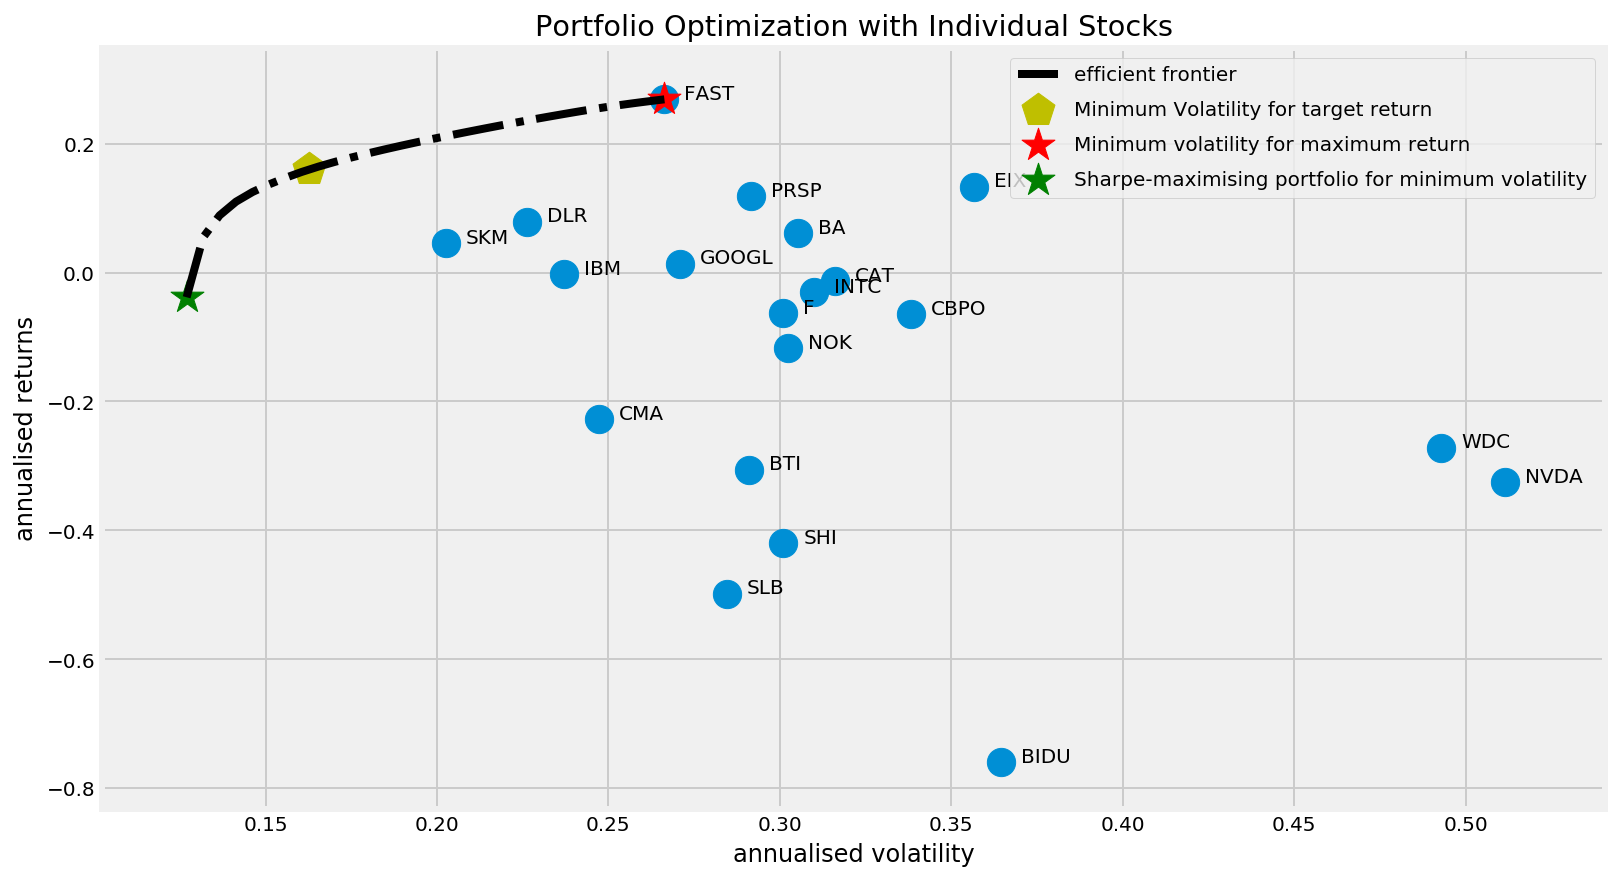

In [66]:
individual_assets = ['PRSP', 'GOOGL', 'IBM', 'BTI', 'BA', 'BIDU', 'CMA', 'WDC', 'SLB', 'SKM', 'F', 'EIX', 'FAST', 'NOK', 'DLR', 'INTC', 'CBPO', 'NVDA', 'SHI', 'CAT']
# individual_assets = ['PRSP', 'SKM', 'EIX', 'FAST', 'DLR']
t_return_opt = 0.16
i_stocks_assets_data = prices_df[individual_assets].copy()

max_annual_return_portfolio = generate_portfolio(prices_df=i_stocks_assets_data, target_return=0.5)
min_annual_volatility_portfolio = generate_portfolio(prices_df=i_stocks_assets_data, target_risk=0.0)
max_annual_volatility_portfolio = generate_portfolio(prices_df=i_stocks_assets_data, target_risk=1.0)
opt_portfolio = generate_portfolio(prices_df=i_stocks_assets_data, target_return=t_return_opt)

i_stocks_perfomance = {}
for a in individual_assets:
    EFmodel = generate_analysis_model(i_stocks_assets_data[a], (0.0, 1.0))
    EFmodel.efficient_return(target_return=1.0)
    i_stocks_perfomance[a] = EFmodel.portfolio_performance(verbose=False)

fig, ax = plt.subplots(figsize=(12, 7))

ax.scatter([p[1] for p in i_stocks_perfomance.values()],
           [p[0] for p in i_stocks_perfomance.values()],
           marker='o',s=200)

for a, p in i_stocks_perfomance.items():
    ax.annotate(a, (p[1],p[0]), xytext=(10,0), textcoords='offset points')

target = np.linspace(min_annual_volatility_portfolio[1], max_annual_return_portfolio[1], 30)
ef_curve_portfolios_perfomance = {}
for t in target:
    EFmodel = generate_analysis_model(i_stocks_assets_data, (0.0, 1.0))
    EFmodel.efficient_risk(target_risk=t)
    ef_curve_portfolios_perfomance[t] = EFmodel.portfolio_performance(verbose=False)
    
target_ret = np.linspace(max_annual_volatility_portfolio[0], max_annual_return_portfolio[0], 30)
for t in target_ret:
    EFmodel = generate_analysis_model(i_stocks_assets_data, (0.0, 1.0))
    EFmodel.efficient_return(target_return=t)
    ef_curve_portfolios_perfomance[t] = EFmodel.portfolio_performance(verbose=False)

    
    
ax.plot([p[1] for p in ef_curve_portfolios_perfomance.values()], 
        [p[0] for p in ef_curve_portfolios_perfomance.values()], 
        linestyle='-.', 
        color='black', 
        label='efficient frontier')
    
ax.scatter(opt_portfolio[1],
           opt_portfolio[0],
           marker='p',color='y',s=300, label='Minimum Volatility for target return')    
    
ax.scatter(max_annual_return_portfolio[1],
           max_annual_return_portfolio[0],
           marker='*',color='r',s=300, label='Minimum volatility for maximum return')

ax.scatter(min_annual_volatility_portfolio[1],
           min_annual_volatility_portfolio[0],
           marker='*',color='g',s=300, label='Sharpe-maximising portfolio for minimum volatility')

ax.set_title('Portfolio Optimization with Individual Stocks')
ax.set_xlabel('annualised volatility')
ax.set_ylabel('annualised returns')
ax.legend(labelspacing=0.8, loc='best')
# ax.savefig("image.png")

As you can see from the above plot, the stock with the least risk is SKM at around 0.20. But with portfolio optimisation, we can achieve even lower risk at 0.14, and still with a higher return than SKM. 
Best risk/return allocation are in FAST in our case and its matched with portfolio optimised for minimum volatility for maximum return.